Importing Necessary Libraries

In [66]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

Reading and Understanding the Data

In [7]:
data = pd.read_csv('house_pred.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Pre-Processing Functions

In [13]:
def ThresholdandND_columnRemoval(df):
    N = len(df)
    columns = df.columns
    for col in columns:
        if (len(df[col].unique()) == 1):
            df = df.drop([col],axis=1)
            continue
        notnull = df[col].isnull().sum()
        ratio = notnull / N
        if(ratio >= 0.30):
            df = df.drop([col],axis=1)
    return df

def Handling_NullValues(df):
    columns = df.columns
    for col in columns:
        typeCol = str(df[col].dtype)
        if typeCol == 'object':
            df = df[df[col].notna()]
        else:
            mean = df[col].mean()
            median = df[col].median()
            standard_deviation = df[col].std()
            pmc = (3 * (mean - median)) / standard_deviation
            if pmc >= 0.4 or pmc <= -0.4:
                df[col] = df[col].fillna(median)
            else:
                df[col] = df[col].fillna(mean)
    return df

def OneHotEncoding_objects(df):
    columns = df.columns
    for col in columns:
        typeCol = str(df[col].dtype)
        if typeCol == 'object':
            enc = pd.get_dummies(df[col])
            encCol = enc.columns
            newColumns = {}
            for i in range(0,len(encCol)):
                newColumns[encCol[i]] = col + encCol[i]
            enc.rename(columns = newColumns, inplace = True)
            df = df.join(enc)
            df = df.drop([col],axis=1)
    return df

def IQR_Removal(df):
    columns = df.columns
    for col in columns:
        if col == 'SalePrice':
            continue
        typeCol = str(df[col].dtype)
        if typeCol != 'object':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            iqr = Q3 - Q1
            df = df[(df[col] >= Q1 - 1.5*iqr) & (df[col] <= Q3 + 1.5*iqr)]
    return df

Result of Pre-Processing

In [14]:
dataFeatures = OneHotEncoding_objects(IQR_Removal(Handling_NullValues(ThresholdandND_columnRemoval(data))))
dataFeatures

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleTypeConLw,SaleTypeNew,SaleTypeOth,SaleTypeWD,SaleConditionAbnorml,SaleConditionAdjLand,SaleConditionAlloca,SaleConditionFamily,SaleConditionNormal,SaleConditionPartial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
10,11,20,70.0,11200,5,5,1965,1965,0.0,906,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,1448,60,80.0,10000,8,5,1995,1996,438.0,1079,...,0,0,0,1,0,0,0,0,1,0
1448,1449,50,70.0,11767,4,7,1910,2000,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1451,1452,20,78.0,9262,8,5,2008,2009,194.0,0,...,0,1,0,0,0,0,0,0,0,1
1454,1455,20,62.0,7500,7,5,2004,2005,0.0,410,...,0,0,0,1,0,0,0,0,1,0


Variance Inflation Factor Filter

In [69]:
def VIF_Filter(df,dfTest):
    xCol = list(set(list(df.columns)) & set(list(dfTest.columns)))
    xCol.remove('Id')
    while(1):
      finished = True
      xVal = df[xCol]
      xVal['intercept'] = 1
      vif = pd.DataFrame()
      vif['variable'] = xVal.columns
      vif['vif'] = [VIF(xVal.values,i) for i in range(xVal.shape[1])]
      for i in range(0,len(vif)):
          var = str(vif.iloc[i,0])
          val = str(vif.iloc[i,1])
          if(var == 'intercept'):
              continue
          elif(val == 'inf'):
              xCol.remove(var)
              finished = False
              break
          else:
              val = float(val)
              if val > 3:
                  xCol.remove(var)
                  finished = False
                  break
      if finished == True:
          return xCol, vif

Pre-Processing 'test.csv' so only common columns are created for input and generating the new columns after the VIF Filter

In [70]:
testingdata = pd.read_csv('test.csv')
testingFeatures = OneHotEncoding_objects(IQR_Removal(Handling_NullValues(ThresholdandND_columnRemoval(testingdata))))
columns, vif = VIF_Filter(dataFeatures,testingFeatures)

<ipython-input-69-7e755e422c58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xVal['intercept'] = 1
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
<ipython-input-69-7e755e422c58>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Checking the Correlation Matrix

<Axes: >

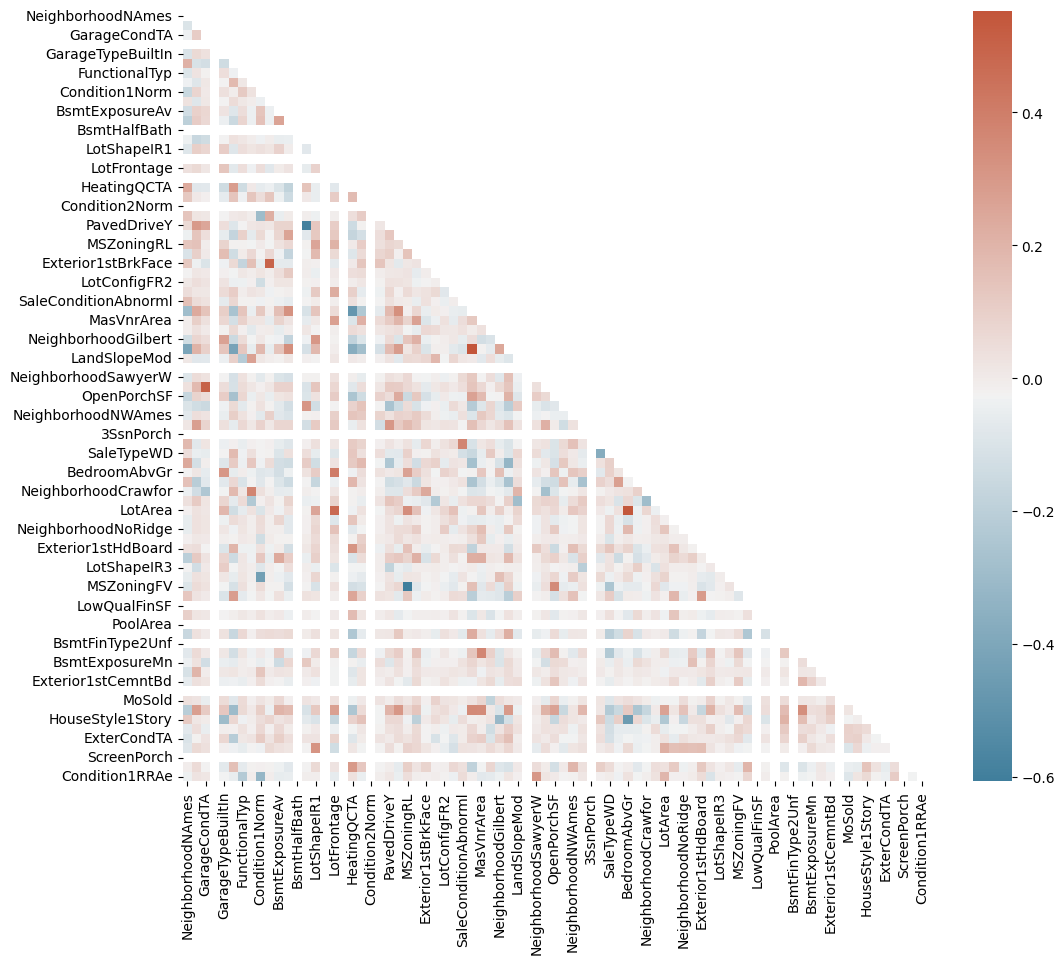

In [71]:
corr = dataFeatures[columns].corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap=cmap)

Training the Model

In [72]:
y = dataFeatures['SalePrice']
x = dataFeatures[columns]
reg = LinearRegression()
reg.fit(x,y)

LinearRegression()

In [73]:
reg.intercept_, reg.coef_

(-2725276.6288485904,
 array([-3.12747862e+04,  6.55764503e+03,  2.10188408e+04, -2.75607874e-08,
         1.50262728e+04,  1.06133717e+03,  1.85314779e+04, -5.92295640e+04,
         2.24514613e+04, -1.42812623e+03,  2.45163194e+03, -1.01269864e+04,
        -1.81898940e-10,  2.59363452e+04, -3.96965569e+03, -7.27595761e-12,
         1.35895120e+02,  6.18456397e-11, -2.10763575e+04,  7.13352728e+03,
        -1.09139364e-11,  1.83627805e+04, -2.72456789e+03,  1.89188523e+03,
         2.15184055e+04,  1.45733871e+04,  2.95053350e+04, -5.02074485e+04,
        -1.17919679e+04,  4.04991689e+03, -8.50929923e+03,  1.14439038e+03,
         4.90620022e+01,  1.36670764e+03, -9.73370629e+03, -7.82661876e+03,
         6.19358665e+03,  1.09139364e-11, -6.49655346e+03,  2.09713078e+04,
         1.81691873e+02, -3.79824531e+04, -2.12023119e+04,  1.14191310e+04,
         7.50333129e-12, -5.61844013e+03, -9.52847617e+03, -2.41087189e+04,
         4.89713061e+03,  1.41793372e+03,  2.34915289e+04, -5.4575

Value Prediction for testing values

In [74]:
x_test = testingFeatures[columns]
y_forTest = reg.predict(x_test)
y_forTest

array([154024.89006091, 185655.26581354, 290000.00000001, 276425.2050283 ,
       199830.12541622, 126597.52761046, 139540.13774717, 129058.04510005,
       198467.86822014, 201980.69256451, 205446.25619611, 204714.85121282,
       197253.22889859, 191247.30645436, 192216.43984082, 157735.08558404,
       181024.60569682, 231027.38520989, 176606.16947115, 169861.89041841,
       221951.14083588, 179252.50873907, 221629.49832791, 187876.53808596,
       177909.12929119, 197350.90691079, 198911.06313266, 194836.51285783,
       248860.64740568, 211614.34420042, 193823.5144481 , 205005.23869346,
       183477.41979756, 188089.7107106 , 231157.19659229, 101338.43214322,
       175802.06215834])

RMSE value for the training dataset of price prediction

In [75]:
y_pred = reg.predict(x)
math.sqrt(mean_squared_error(y,y_pred))

26473.87131550646

R Square Score for Multiple Regression

In [77]:
reg.score(x,y)

0.802510372524533